## Import statements

In [112]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

## View the data as a scatter matrix

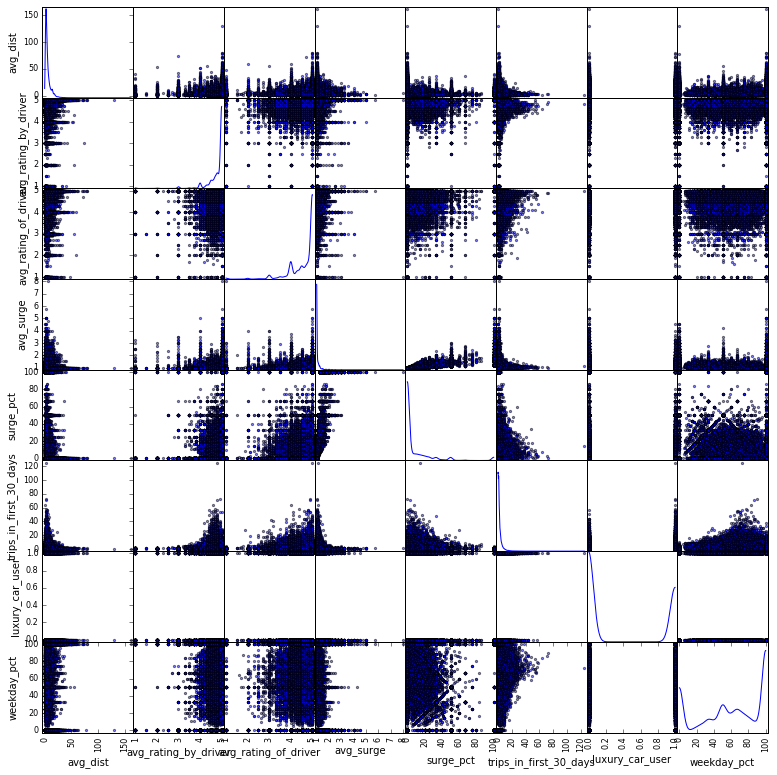

In [114]:
df = pd.read_csv('data/churn.csv')
pd.scatter_matrix(df, diagonal='kde',figsize=(13,13))
plt.savefig('ScatterMatrix.jpg',bbox_inches='tight')
plt.show()

We removed the 369 nulls in the "phone" category.  Of the nulls, 33% were retained users.  About 37% of the overall population is retained, so we didn't think the null phone group should be a strong predictor of retention.  

## Load data and perform cleaning

In [106]:
df = pd.read_csv('data/churn.csv')

def convert_dates(data, cols):
    '''
    INPUT:
        data - DataFrame to convert dates within
        cols - list of columns containing dates, not in datetime format
    OUTPUT:
        DataFrame with cols converted to datetime objects
    '''
    for col in cols:
        data[col] = pd.to_datetime(data[col])
    return data


def convert_nan(data, cols):
    '''
    INUPT:
        data - DataFrame
        cols - list of columns to convert nan's to 0
    OUTPUT:
        DataFrame with 0 instead of nan's
    '''
    for col in cols:
        data.loc[pd.isnull(data[col]), col] = 0.1
    return data


def bin_data(data, cols, bins, group_names):
    '''
    INUPT:
        data - DataFrame
        cols - list of columns to bin
        bins - list of values on which to bin
        group_names - list of lists of names for bins
    OUTPUT:
        DataFrame with original columns containing bin names corresponding to
            original column values
    '''
    for i, col in enumerate(cols):
        categories = pd.cut(data[col], bins, labels=group_names[i])
        data[col] = categories.astype('string')
    return data


def add_dummies(data,
                cols,
                make_bins=False,
                make_zeros=False,
                bins=None,
                group_names=None,):
    '''
    INPUT:
        data - DataFrame
        cols - list of columns to create dummy columns from
        make_bins - boolean corresponding on whether to bin data before creating
               dummies
        bins - list of values on which to bin if making bins
        group_names - list of names for bins if making bins
        convert_nan - boolean corresponding on wheter to handle nan's
    OUTPUT:
        DataFrame with dummies added, and original column removed
    '''
    if make_zeros is True:
        data = convert_nan(data, cols)
    if make_bins is True:
        data = bin_data(data, cols, bins, group_names)
    for col in cols:
        dummies = pd.get_dummies(data[col], drop_first=True)
        data = pd.concat([data, dummies], axis=1)
        data = data.drop(col, axis=1)
    return data


def check_weekend(data, columns):
    '''
    INPUT:
        data - DataFrame
        cols - list of columns containing dates
    OUTPUT:
        DataFrame with boolean columns added for to differentiate weekend from weekday
    '''
    for col in columns:
        # identify as weekend if day >=4 (this will include Friday, Saturday, and Sunday)
        data[col+'_is_wknd'] = data[col].dt.dayofweek >= 4
    return data
    


if __name__ == '__main__':
    # Identify and convert columns contaiing dates to datetime objets
    df = convert_dates(df, ['last_trip_date', 'signup_date'])

    # Identify columns for dummy variables, add dummies and remove original columns
    wdf = add_dummies(df, ['city'])

    # Calculate churn date
    date = wdf.last_trip_date.max() - pd.Timedelta(days=30)

    # Create Retained boolean column
    wdf['Retained'] = wdf.last_trip_date >= date

    # Create bins for ratings and add dummies for those bins (handles nan values)
    bins = [0,0.9,1.9,2.9,3.9,4.9,5]
    wdf = add_dummies(wdf,
                      ['avg_rating_by_driver', 'avg_rating_of_driver'],
                      make_bins=True,
                      make_zeros=True,
                      bins=bins,
                      group_names=[['dr_NR',
                                    'dr_ones',
                                    'dr_twos',
                                    'dr_threes',
                                    'dr_fours',
                                    'dr_fives'],
                                   ['ur_NR',
                                    'ur_ones',
                                    'ur_twos',
                                    'ur_threes',
                                    'ur_fours',
                                    'ur_fives']])
    
    # add columns identifying whether signup date and last trip date were on weekends
    wdf = check_weekend(wdf, columns = ['last_trip_date', 'signup_date'])

    # Drop values of phone == Null
    wdf = wdf.drop(wdf.loc[pd.isnull(wdf.phone) == True].index, axis=0)
wdf.head()

,avg_dist,avg_surge,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,King's Landing,...,dr_ones,dr_threes,dr_twos,ur_fives,ur_fours,ur_ones,ur_threes,ur_twos,last_trip_date_is_wknd,signup_date_is_wknd
0,3.67,1.10,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,True
1,8.26,1.00,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False,False
2,0.77,1.00,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False
3,2.36,1.14,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,True
4,3.13,1.19,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,False


## Separate the factors and targets into x and y variables and split into test and train sets

In [107]:
y = wdf['Retained'].values
X1 = wdf.drop(['Retained', 'last_trip_date', 'phone', 'signup_date'],axis=1)
X = wdf.drop(['Retained', 'last_trip_date', 'phone', 'signup_date'],axis=1).values

train_x, test_x, train_y, test_y = train_test_split(X, y)

## Create and Compare Models
#### Perform grid search for best parameters on random forest classifier and gradient boosting classifier.

In [108]:
rf = RandomForestClassifier(n_estimators=100,
                           n_jobs=-1,
                           random_state=1)

gdbr = GradientBoostingClassifier(learning_rate=0.1,
                                 loss='ls',
                                 n_estimators=100,
                                 random_state=1)

rf_grid = {'max_depth': [None],
           'max_features': [7],
           'min_samples_split': [1],  
           'min_samples_leaf': [15, 16, 17],
           'n_estimators': [70],
           'random_state': [1]}

gd_grid = {'learning_rate': [.11, 0.1],
           'max_depth': [7],
           'min_samples_leaf': [19, 20, 21],
           'max_features': [.6],
           'n_estimators': [100],
           'random_state': [1]}

def grid_search(est, grid):
    grid_cv = GridSearchCV(est, grid, n_jobs=-1, verbose=True,
                           scoring='mean_squared_error', cv=5).fit(train_x, train_y)
    return grid_cv

In [71]:
'''Run a grid search on the random forest classifier to determine the best input parameters'''
rf_grid_search = grid_search(RandomForestClassifier(), rf_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bit

In [52]:
'''Run a grid search on the gradient boosting classifier to determine the best input parameters'''
gd_grid_search = grid_search(GradientBoostingClassifier(), gd_grid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/sydneydecoto/anaconda2/lib/python2.7/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bit

In [104]:
rf_best = rf_grid_search.best_estimator_
gd_best = gd_grid_search.best_estimator_
print 'Gradient Boost Params:\n', gd_grid_search.best_params_
print '\nRandom Forest Params:\n', rf_grid_search.best_params_

Gradient Boost Params:
{'learning_rate': 0.1, 'min_samples_leaf': 20, 'n_estimators': 100, 'random_state': 1, 'max_features': 0.6, 'max_depth': 7}

Random Forest Params:
{'min_samples_leaf': 15, 'n_estimators': 70, 'min_samples_split': 1, 'random_state': 1, 'max_features': 7, 'max_depth': None}


## Use the best parameters identified in the grid seach to train final models

In [109]:
# Train the random forest model with best parameters
rf_opt = RandomForestClassifier(bootstrap=False, min_samples_leaf=15, n_estimators=100, min_samples_split=1,
                                random_state=1, max_features=7, max_depth=None)
rf_opt.fit(train_x, train_y)
rf_opt.score(test_x, test_y)
print 'Accuracy Score of Optimized Random Forest: ', rf_opt.score(test_x, test_y)

# Train the gradient boosting classifier model with best parameters
gd_opt = GradientBoostingClassifier(learning_rate=0.1, min_samples_leaf=20, n_estimators=100, random_state=1,
                                max_features=.6, max_depth=7)
gd_opt.fit(train_x, train_y)
gd_opt.score(test_x, test_y)
print 'Accuracy Score of Optimized Gradient Boosting Classifier: ', gd_opt.score(test_x, test_y)

Accuracy Score of Optimized Random Forest:  0.775260059673
Accuracy Score of Optimized Gradient Boosting Classifier:  0.780179017821


## Plot Feature Importance

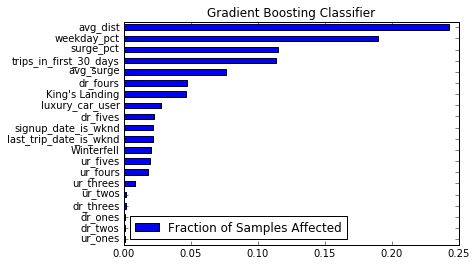

In [80]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gd_opt.feature_importances_}, index= X1.columns)

feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')
plt.title('Gradient Boosting Classifier')
plt.savefig('GB_Features.jpg',bbox_inches='tight')

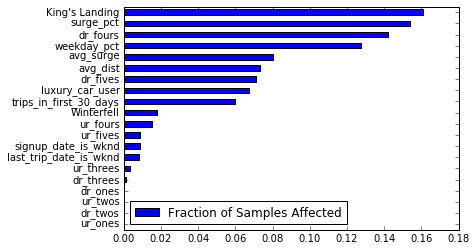

In [79]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf_opt.feature_importances_}, index= X1.columns)

feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')
plt.savefig('RF_Features.jpg',bbox_inches='tight')